<a href="https://colab.research.google.com/github/rajatdua/dlvr-fgmccb/blob/main/DLVR_Project_FGMCCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Visual Recognition Project

In this project, We will utilize the Caltech-UCSD Birds 200 (CUB-200-2011) dataset, which comprises a total of 11,788 images depicting 200 distinct bird species. The dataset exhibits a notably **balanced distribution**, with 50 to 60 images available for each individual species. It includes detailed annotations specifying the locations of specific anatomical parts of the birds.

## Fine Grained Multi-Class Classification of Birds (FGMCCB)

Our primary focus will be on employing **EfficientNetB5** for image encoding and implementing a decoder for classification. Due to the inherent similarities among bird features and the challenge of distinguishing them, we will employ the **Triplet Loss**. This loss function encourages the network to minimize the distance between anchor and positive samples while increasing the separation from negative samples within the embedding space. In addition, we will also leverage the **Cross-Entropy Loss**.

### Dataset Classification

#### Source
You can find the source dataset from [here](http://www.vision.caltech.edu/datasets/cub_200_2011/).

#### Details
- Number of categories: 200
- Number of images: 11,788
- Input image dimensions: 224 x 224
- Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

#### Tech-Stack
- Language: Python
- Framework: PyTorch




#### **Step 1: Data Pre-Processing**

1. Mount the google drive and download the dataset
2. Divide the dataset in training, validation and testing datasets

**Note**: Use data augumentation to increase the dataset working space

##### **Step 1.1: Mount the google drive and download the dataset**

In [ ]:
import os
from google.colab import drive
import requests
from tqdm import tqdm
import tarfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset URL
dataset_url = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"

# Define the local directory to save the dataset
# local_dir = '/content/dataset'
drive_dir = '/content/drive/My Drive/Datasets'

dataset_file = 'CUB_200_2011.tgz'
extracted_folder = 'CUB_200_2011'

# Check if the directory already exists
if not os.path.exists(drive_dir):
    os.makedirs(drive_dir)

# Check if the directory is empty - removed this because it is more robust to check
# if not os.listdir(local_dir):

# Check if the dataset file and folder exist
if not os.path.exists(os.path.join(drive_dir, dataset_file)):
    # Download the dataset
    response = requests.get(dataset_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    t = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(os.path.join(drive_dir, 'CUB_200_2011.tgz'), 'wb') as file, tqdm(
        desc='Downloading',
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            t.update(len(data))
            bar.update(len(data))
            file.write(data)
    t.close()

if not os.path.exists(os.path.join(drive_dir, extracted_folder)):
    # Extract the dataset
    with tarfile.open(os.path.join(drive_dir, 'CUB_200_2011.tgz'), 'r:gz') as tar:
        tar.extractall(drive_dir)
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists in the directory. Skipping download and extraction.")


Mounted at /content/drive
Dataset already exists in the directory. Skipping download and extraction.


In [ ]:
import os

# List files in /content folder
print("Files in /content folder:")
for file in os.listdir('/content'):
    print(file)

# List files in /content/drive/My Drive/Datasets folder
print(f"\nFiles in {drive_dir} folder:")
for file in os.listdir(drive_dir):
    print(file)

# List files in /content/drive/My Drive/Datasets/CUB_200_2011 folder
print(f"\nFiles in {drive_dir}/{extracted_folder} folder:")
for file in os.listdir(f'{drive_dir}/{extracted_folder}'):
    print(file)


Files in /content folder:
.config
drive
sample_data

Files in /content/drive/My Drive/Datasets folder:
attributes.txt
CUB_200_2011.tgz
CUB_200_2011
CUB_200_2011_divided

Files in /content/drive/My Drive/Datasets/CUB_200_2011 folder:
parts
images.txt
train_test_split.txt
bounding_boxes.txt
classes.txt
image_class_labels.txt
attributes
README
images


#### **Step 2: Basic EfficientB5 Baseline**

In [ ]:
# Prerequisite to update - not needed at the moment
!pip install torch torchvision --upgrade
!pip install torchvision --upgrade

## Baseline Version 2

### Downloading Prerequisite
1. efficientnet_pytorch - Contains all the efficient-net models.
2. torchinfo - Formats the model summary in a viewable manner.
3. matplotlib - For plotting graphs, etc.

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3024e3bcb9f2284b5eccf2fa7eeef4d5ea5b92c81f7baaef4783292cefab1cad
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
!pip install torchinfo

In [ ]:
!pip install matplotlib

### Imports

In [ ]:
import torch
import time
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from efficientnet_pytorch import EfficientNet
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import cv2

In [ ]:
class RandomOcclusion(object):
    def __init__(self, occlusion_prob=0.5, max_occlusion_size=0.2):
        self.occlusion_prob = occlusion_prob
        self.max_occlusion_size = max_occlusion_size

    def __call__(self, image):
        if np.random.rand() < self.occlusion_prob:
            h, w, _ = image.shape
            occlusion_mask = np.ones((h, w, 3), dtype=np.uint8)
            occlusion_size = int(self.max_occlusion_size * min(h, w))

            # Randomly select the position of the occlusion
            top = np.random.randint(0, h - occlusion_size)
            left = np.random.randint(0, w - occlusion_size)

            # Apply occlusion (e.g., black rectangle)
            occlusion_mask[top:top + occlusion_size, left:left + occlusion_size, :] = 0
            image = cv2.add(image, occlusion_mask)

        return image

In [ ]:
if torch.cuda.is_available():
  print('GPU is available')
else:
  print('GPU is not available')

# input_size = (456, 456)
# Original
input_size = (224, 224)

# Load the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/'

# without data augementation
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# with data augementataion
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

#with occlusion and data augemntation
#transform = transforms.Compose([
#    RandomOcclusion(occlusion_prob=0.5, max_occlusion_size=0.2),
#    transforms.RandomResizedCrop(input_size),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.RandomRotation(15),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

# possible color adjustments to be added (after RandomRotation beforeToTensor)
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust image color
#    transforms.RandomGrayscale(p=0.1),  # Randomly apply grayscale
#    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Apply perspective transformation

dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.6 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = int((len(dataset) - train_size)/2)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# test_dataset 60% 20% 20%
# test_dataset 80% 10% 10%

# Occulusion added - masking
# Occulusion needs to be updated for the annotations / attributes (parts of bird)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2) #shuffle - should the data be randomly shuffled during each epoch of training
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the pre-trained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Used in saving the model as well
model_type = 'b0'

model = EfficientNet.from_pretrained(f'efficientnet-{model_type}')

# Print the model summary
print(torchinfo.summary(model))

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (adjust as needed)
for param in model._conv_head.parameters():
    param.requires_grad = True
for param in model._bn1.parameters():
    param.requires_grad = True
for param in model._fc.parameters():
    param.requires_grad = True

num_classes = 200

model._fc = nn.Linear(model._fc.in_features, num_classes)

# Loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


# Early stopping parameters
patience = 10
early_stopping_counter = 0
best_loss = None

# Training loop
train_losses = []
val_losses = []

max_epoch = 20;

all_predictions = []
all_labels = []

# Moved it down, because the model was in different device
model = model.to(device)

for epoch in range(max_epoch):  # Adjust as needed
    print(f'Starting Epoch: {epoch + 1}')
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    print(f'Size: {len(train_dataloader.dataset)}')
    start_time = time.time()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    end_time = time.time()
    #scheduler.step()

    execution_time = end_time - start_time
    print(f'Training {epoch + 1} took {execution_time} ms')

    # Validation phase
    start_time_v = time.time()
    correct = 0
    total = 0
    top1_correct = 0
    top5_correct = 0
    model.eval()
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Calculate top-1 error
        top1_correct += predicted.eq(labels).sum().item()

        # Calculate top-5 error
        _, top5_predicted = outputs.topk(5, dim=1)
        top5_correct += top5_predicted.eq(labels.view(-1, 1)).sum().item()

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    end_time_v = time.time()

    # Calculate top-1 error percentage
    top1_error = 100 * (1 - top1_correct / total)
    # Calculate top-5 error percentage
    top5_error = 100 * (1 - top5_correct / total)

    print(f'Top-1 Error: {top1_error}%')
    print(f'Top-5 Error: {top5_error}%')

    execution_time_v = end_time_v - start_time_v
    print(f'Validating {epoch + 1} took {execution_time_v} ms')

    # Calculate average losses
    train_loss = train_loss / len(train_dataloader.dataset)
    val_loss = val_loss / len(val_dataloader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Accuracy: {100 * correct / total}%')

    # Check for early stopping - Maybe check PyTorch in-build early stopping mechanism
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered')
        break
    print(f'Ending Epoch: {epoch + 1}')

# Plotting the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print or visualize the results
for i in range(len(all_predictions)):
    print(f"Sample {i + 1}: Predicted={all_predictions[i]}, Actual={all_labels[i]}")


GPU is available
Device: cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 200MB/s]


Loaded pretrained weights for efficientnet-b0
Layer (type:depth-idx)                             Param #
EfficientNet                                       --
├─Conv2dStaticSamePadding: 1-1                     864
│    └─ZeroPad2d: 2-1                              --
├─BatchNorm2d: 1-2                                 64
├─ModuleList: 1-3                                  --
│    └─MBConvBlock: 2-2                            --
│    │    └─Conv2dStaticSamePadding: 3-1           288
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─Conv2dStaticSamePadding: 3-3           264
│    │    └─Conv2dStaticSamePadding: 3-4           288
│    │    └─Conv2dStaticSamePadding: 3-5           512
│    │    └─BatchNorm2d: 3-6                       32
│    │    └─MemoryEfficientSwish: 3-7              --
│    └─MBConvBlock: 2-3                            --
│    │    └─Conv2dStaticSamePadding: 3-8           1,536
│    │    └─BatchNorm2d: 3-9                       192
│    │    └─Conv2dStat

NameError: ignored

### Save Model

In [ ]:
# saving the trained baseline ENB5 model
import time

def generate_save_path(model_type, replacer_value):
    common_save_path = f'/content/drive/MyDrive/TrainedModels/baseline_en{model_type}_model_{int(time.time())}{replacer_value}.pth'
    return common_save_path

model_save_path_dict = generate_save_path(model_type, '_dict');

import os

if not os.path.exists(model_save_path_dict):
  os.makedirs(os.path.dirname(model_save_path_dict), exist_ok=True)

torch.save(model.state_dict(), model_save_path_dict)
print(f"Trained model saved at {model_save_path_dict}")

model_save_path = generate_save_path(model_type, '');

torch.save(model, model_save_path)
print(f"Trained model saved at {model_save_path}")

## Load from Model

In [ ]:
# Load the model from saved directory
from google.colab import drive
drive.mount('/content/drive')

# Set the path to the saved model
model_load_path_dict = f'/content/drive/MyDrive/TrainedModels/baseline_en{model_type}_model_dict.pth'

# Create an instance of the model - Needs to be fixed, convert it to version 2 baseline (not version 1) - Rewrite to make it reusable
loaded_model = EfficientNetB5Model(num_classes)

# Load the state dictionary into the model
loaded_model.load_state_dict(torch.load(model_load_path_dict))

# Set the model to evaluation mode (important if using layers like dropout)
loaded_model.eval()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded pretrained weights for efficientnet-b5


EfficientNetB5Model(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStat

In [ ]:
# Compute and print Precision and Recall
from sklearn.metrics import precision_score, recall_score

# By using 'macro'-averaging, calculate metrics for each label and find their mean (instead of 'micro'-averaging which calculates metrics globally)
# Warning: Be cautious with label imbalances
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Precision={precision}, Recall={recall}")

Precision=0.6369847980107268, Recall=0.6351475173003811


### Confusion Matrix

Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 1  7  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0 13]]


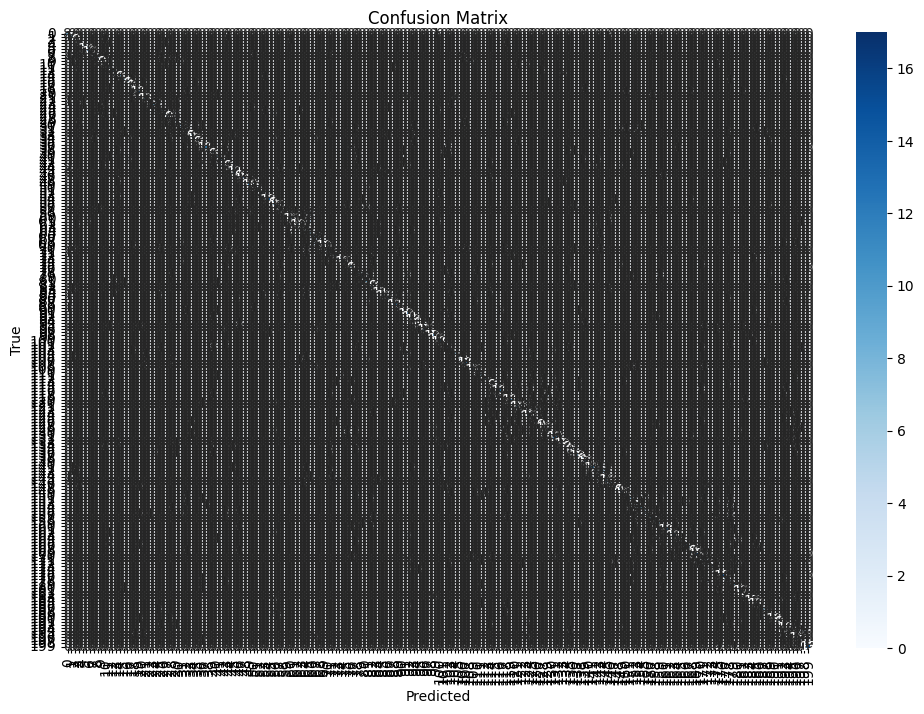

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


!pip install matplotlib

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### **Step 3.1: Tweak Decoder - Fine Grained using Annotations**

In [ ]:
# Attributes txt [Parts of Bird] < Included!!!!!!

#### **Step 3.2: Include Loss Functions - Cross Entropy + Triplet Loss**

#### **Step 4: Calculate Training and Validation Loss**

#### **Step 5.1: Calculate Top-1, Top-5 Error**

#### **Step 5.2: Compare Custom CNN vs Baseline**

#### **Step 6: Benchmarking - mAP (mean average precision), F-Score**

#### **Step 7: Confusion Matrix b/w Similar Classes**

# Appendix

##### **Step 1.2: Divide the dataset in training, validation and testing datasets**

In [ ]:
# not needed at the moment
!pip install split-folders

In [ ]:
# not needed at the moment
import splitfolders

input = '/content/drive/MyDrive/Datasets/CUB_200_2011/images'
output ='/content/drive/MyDrive/Datasets/CUB_200_2011_divided'


# Set a tuple as "ratio" to split the dataset into training, validation and test set
# Other ratios to consider: .7, .15, .15 or .6, .2, .2
splitfolders.ratio(input, output=output, seed=42, ratio=(.8, .1, .1), group_prefix=None)


Copying files: 11788 files [01:47, 109.87 files/s]


## Baseline Version 1

In [ ]:
# Version 1

import torch

torch.hub._download_url_to_file = lambda url, filename, **kwargs: (filename, True)

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

# Define constants
input_size = (456, 456)  # EfficientNetB5 input size
num_classes = 200  # Number of bird species in CUB-200-2011

from efficientnet_pytorch import EfficientNet

should_freeze_layer = False

# Create a basic EfficientNetB5 model
class EfficientNetB5Model(nn.Module):
    def __init__(self, num_classes, freeze_layers=True):
        super(EfficientNetB5Model, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes)
        if freeze_layers:
          for param in self.base_model.parameters():
              param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)


# Create a basic EfficientNetB5 model - EFB5 from torchvision
# class EfficientNetB5Model(nn.Module):
#     def __init__(self, num_classes):
#         super(EfficientNetB5Model, self).__init__()
#         self.base_model = models.efficientnet_b5(pretrained=True)
#         in_features = self.base_model._fc.in_features
#         self.base_model._fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.base_model(x)

# Instantiate the model
model = EfficientNetB5Model(num_classes, freeze_layers=should_freeze_layer)

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torch.cuda.empty_cache()

# Print the model summary
print(model)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement gradient clipping to limit the magnitude of gradients during training. This can help prevent exploding gradients and save memory.
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Modify the data loading part
transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Specify the path to the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/'

# Create the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
# Changed batch size from 32 to 16 to 8 - it worked with 8 (12.4 GB GPU), failed with 32 & 16 because of out of memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

accumulation_steps = 2  # Accumulate gradients for every two batches

# Lists to store training and validation losses -- ADDED LATER (NEED TO RETRAIN)
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Start of epoch: #{epoch + 1}')
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
         # Backward pass only for parameters that require gradients
        # if any(param.requires_grad for param in model.parameters()):
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.zero_grad()
        # loss.backward() - Put inside if statement because freeze_layer True for some layers doesn't calculate the gradient
        # Accumulate gradients
        # if (i + 1) % accumulation_steps == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ADDED LATER - NEED TO RETRAIN
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%")

# Plot training and validation loss curves - ADDED LATER (NEED TO RETRAIN)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

print(f'End of epoch: #{epoch + 1}')


Loaded pretrained weights for efficientnet-b5
EfficientNetB5Model(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()

KeyboardInterrupt: ignored